# World Water Toolbox

This is an example of the processing chain of using the World Water Toolbox with the openEO Platform. 
The Processing chain is divided to 3 main sub-flows.

![flow](images/flow.PNG)

- Import libraries

In [1]:
import numpy as np

import pathlib
from datetime import datetime
from dateutil.relativedelta import *

import openeo

from openeo.extra.spectral_indices.spectral_indices import append_index
from openeo.processes import exp, array_element,log, count,normalized_difference, gte, eq, neq, sum
from openeo.processes import if_
import xarray as xr

import scipy.signal

 - authenticate_oidc with the openeo backend 

In [2]:
connection = openeo.connect("openeo-dev.vito.be").authenticate_oidc()  #openeo.cloud
# connection.describe_account()

Authenticated using refresh token.


# Input parameters


- Specify the Area of Interest

In [3]:
# Colombbia
# center = [4.707, -73.987]
# zoom   = 12
# eoMap  = openMap(center,zoom)
# eoMap.map

# bbox            = eoMap.getBbox()
# spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
# print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

# 1 ) *Sentinel-2 ARD Pre-Processing*


* Specify collections :
  
  * **SENTINEL2_L1C** (EODC) - Missing Zenith Azimuth, support FORCE and Fmask

  * **SENTINEL2_L1C_SENTINELHUB** (TerraScope backend) - supports SMAC and iCor atmospheric correction

  * **boa_sentinel_2** (EODC) -  (ARD)  processed with FORCE. Missing Zenith and Azimuth information, cloud mask needs to be applied


  * **SENTINEL2_L2A_SENTINELHUB** (TerraScope backend) - Having Zenith and Azimuth information,  (ARD) processed with sen2cor., cloud mask needs to be applied

  Read more about ARD https://docs.openeo.cloud/usecases/ard/msi/#reference-implementations



![S2](images/S2_v1.png)

* Specify temporal extent and bands:

In [5]:

start_date           = '2021-06-01'
spatial_extent       = {'west': -74.06810760, 'east': -73.90597343, 'south': 4.689864510, 'north': 4.724080996, 'crs': 'epsg:4326'} #colombia
zone                 = "tropical"


- Static Variables 

In [6]:
## Get the Sentinel-2 data for a 3 month window.
start_date_dt_object = datetime.strptime(start_date, '%Y-%m-%d')
end_date             = (start_date_dt_object + relativedelta(months = +2)).date() ## End date, 1 month later (1st Feb. 2021)
start_date_exclusion = (start_date_dt_object + relativedelta(months = -2)).date() ## exclusion date, to give a 3 month window.

bands                = ['B02', 'B03', 'B04', 'B08', 'CLP', 'SCL' , 'sunAzimuthAngles', 'sunZenithAngles'] 


-  Specify the region based on this webpage https://ecoregions.appspot.com/ 

In [7]:

LOOKUPTABLE = {
    'tropical': 
       {
        'S1': '1 / (1 + exp(- (-7.17 + (-0.48 * VV))))',
        'S2': '1 / (1 + exp(- (0.845 + (2.14 * NDVI) + (13.5 * NDWI))))',
        'S1_S2':'1 / (1 + exp(- (-2.64 + (-0.23 * VV) + (8.6 * NDWI))))'
        },
    'subtropical': 
       {
        'S1': '1 / (1 + exp(- (-8.1 + (-0.13 * VV) + (-0.27 * VH))))',
        'S2': '1 / (1 + exp(- (0.845 + (2.14 * NDVI) + (13.5 * NDWI))))',
        'S1_S2':'1 / (1 + exp(- (-2.64 + (-0.23 * VV) + (8.6 * NDWI))))'
        }
    }



*A)  Load S2 collection for a 3 month window*

In [8]:
s2_cube = connection.load_collection(
    'SENTINEL2_L2A_SENTINELHUB',
    spatial_extent  = spatial_extent,
    temporal_extent = [start_date_exclusion, end_date],
    bands           = bands)

- (Optional)  Download and Visualize the S2 scenes 

In [6]:
s2_cube_save = s2_cube.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_save.send_job(title="S2L2A_cube")
results = my_job.start_and_wait().get_results()
results.download_files("S2L2A_cube")

ds_s2_cube = xr.open_dataset("S2L2A_cube/openEO.nc").load()
ds_s2_cube[['B02', 'B03', 'B04']].to_array().plot.imshow(x="x", robust=True, col ="t", col_wrap=5,vmin=0, vmax=3000, figsize=(40, 10));
 

C:\Users\ansu\AppData\Local\Temp\ipykernel_5928\2152007623.py:2: DeprecationWarning: Call to deprecated method `send_job`, use `create_job` instead.
  my_job  = s2_cube_save.send_job(title="S2L2A_cube")


0:00:00 Job 'j-05a882cc4fd54b56b428b60d91062955': send 'start'
0:00:19 Job 'j-05a882cc4fd54b56b428b60d91062955': queued (progress N/A)
0:00:25 Job 'j-05a882cc4fd54b56b428b60d91062955': queued (progress N/A)
0:00:32 Job 'j-05a882cc4fd54b56b428b60d91062955': queued (progress N/A)
0:00:40 Job 'j-05a882cc4fd54b56b428b60d91062955': queued (progress N/A)
0:00:50 Job 'j-05a882cc4fd54b56b428b60d91062955': queued (progress N/A)
0:01:03 Job 'j-05a882cc4fd54b56b428b60d91062955': queued (progress N/A)
0:01:19 Job 'j-05a882cc4fd54b56b428b60d91062955': running (progress N/A)
0:01:38 Job 'j-05a882cc4fd54b56b428b60d91062955': running (progress N/A)
0:02:03 Job 'j-05a882cc4fd54b56b428b60d91062955': running (progress N/A)
0:02:33 Job 'j-05a882cc4fd54b56b428b60d91062955': running (progress N/A)
0:03:11 Job 'j-05a882cc4fd54b56b428b60d91062955': running (progress N/A)
0:03:58 Job 'j-05a882cc4fd54b56b428b60d91062955': running (progress N/A)


*B) Mask Clouds, Shadows and Snow*


In [9]:
# Scene classification data, based on Sen2Cor
# scl == 3    Cloud Shadows 
# scl == 8    Clouds medium probability
# scl == 9    Clouds high probability
# scl == 10   Cirrus
# scl == 11   Snow / Ice

scl = s2_cube.band("SCL")
mask_scl = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10) |(scl == 11)
# mask {1 = cloud, 0 = free cloud}
s2_cube = s2_cube.mask(mask_scl)

# CLP (cloud probabilities) based on S2cloudless (160 blocks and 10m resolution)
clp = s2_cube.band("CLP")
mask_clp = (clp / 255) > 0.3  
# mask {1 = cloud, 0 = free cloud}
s2_cube = s2_cube.mask(mask_clp)


- (Optional)  Download and Visualize of S2 scenes masked

C:\Users\ansu\AppData\Local\Temp\ipykernel_18632\3294430042.py:2: DeprecationWarning: Call to deprecated method `send_job`, use `create_job` instead.
  my_job  = s2_cube_save.send_job(title="s2_cube_cloudfree")


0:00:00 Job 'j-44a44e3607cd4f749da130723cb4f04b': send 'start'
0:00:23 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:00:29 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:00:35 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:00:44 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:00:54 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:01:07 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:01:23 Job 'j-44a44e3607cd4f749da130723cb4f04b': queued (progress N/A)
0:01:42 Job 'j-44a44e3607cd4f749da130723cb4f04b': running (progress N/A)
0:02:07 Job 'j-44a44e3607cd4f749da130723cb4f04b': running (progress N/A)
0:02:37 Job 'j-44a44e3607cd4f749da130723cb4f04b': running (progress N/A)
0:03:15 Job 'j-44a44e3607cd4f749da130723cb4f04b': running (progress N/A)
0:04:02 Job 'j-44a44e3607cd4f749da130723cb4f04b': running (progress N/A)
0:05:00 Job 'j-44a44e3607cd4f749da130723cb4f04b': running (progress 

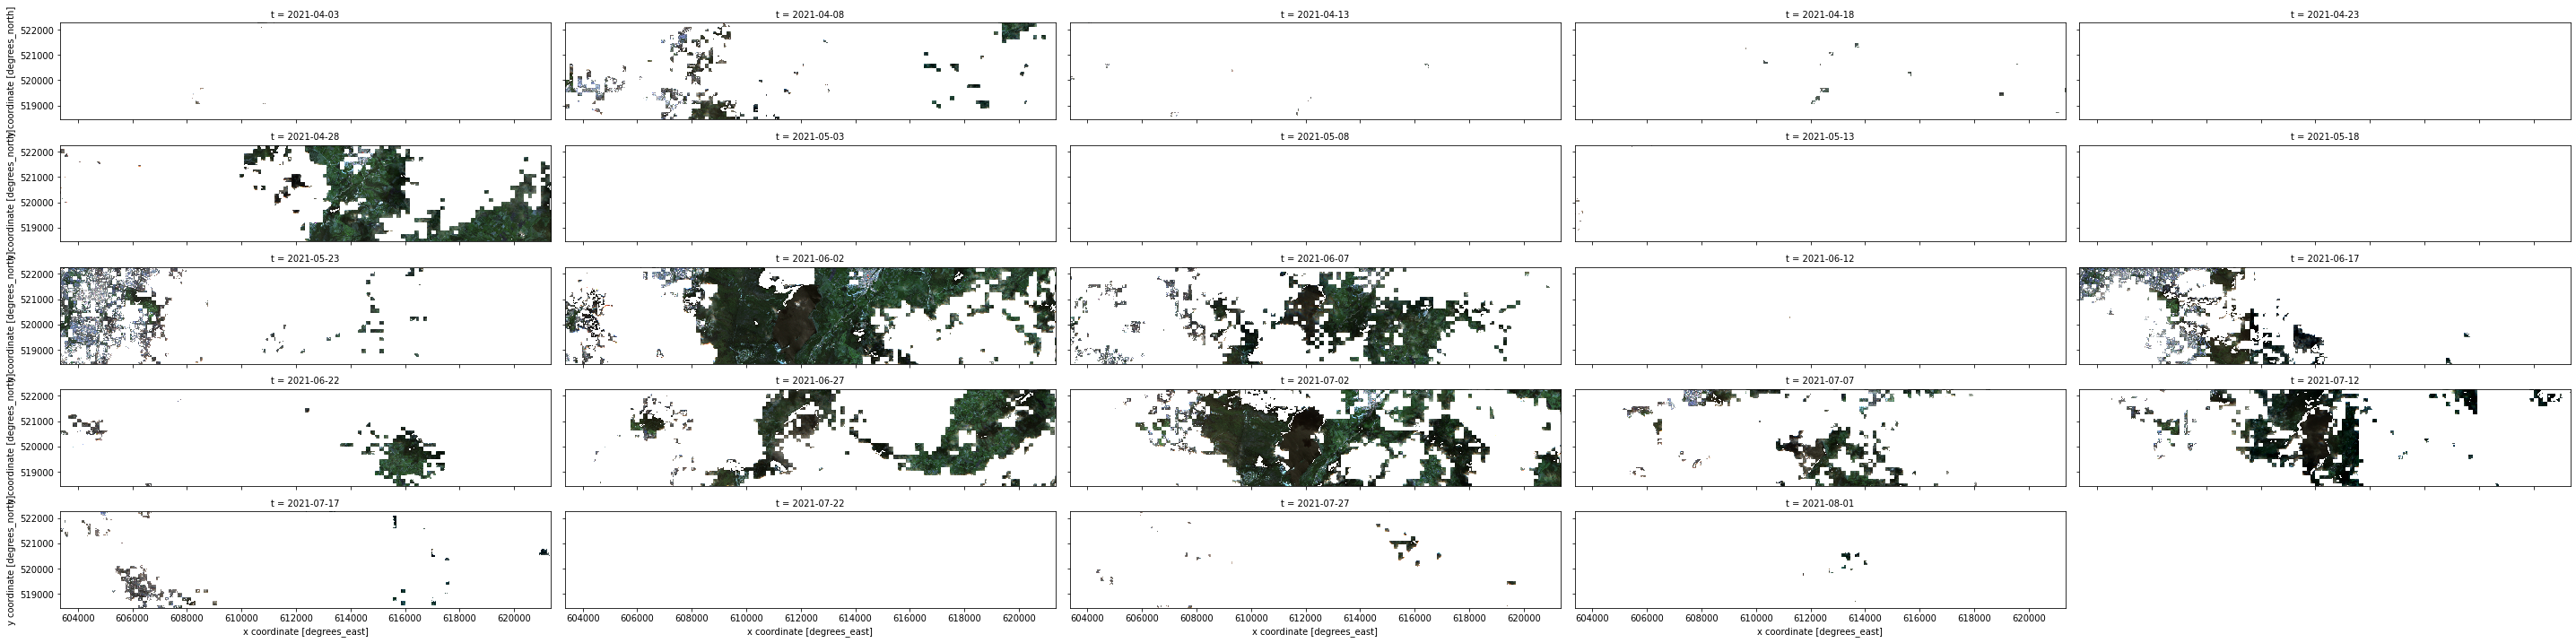

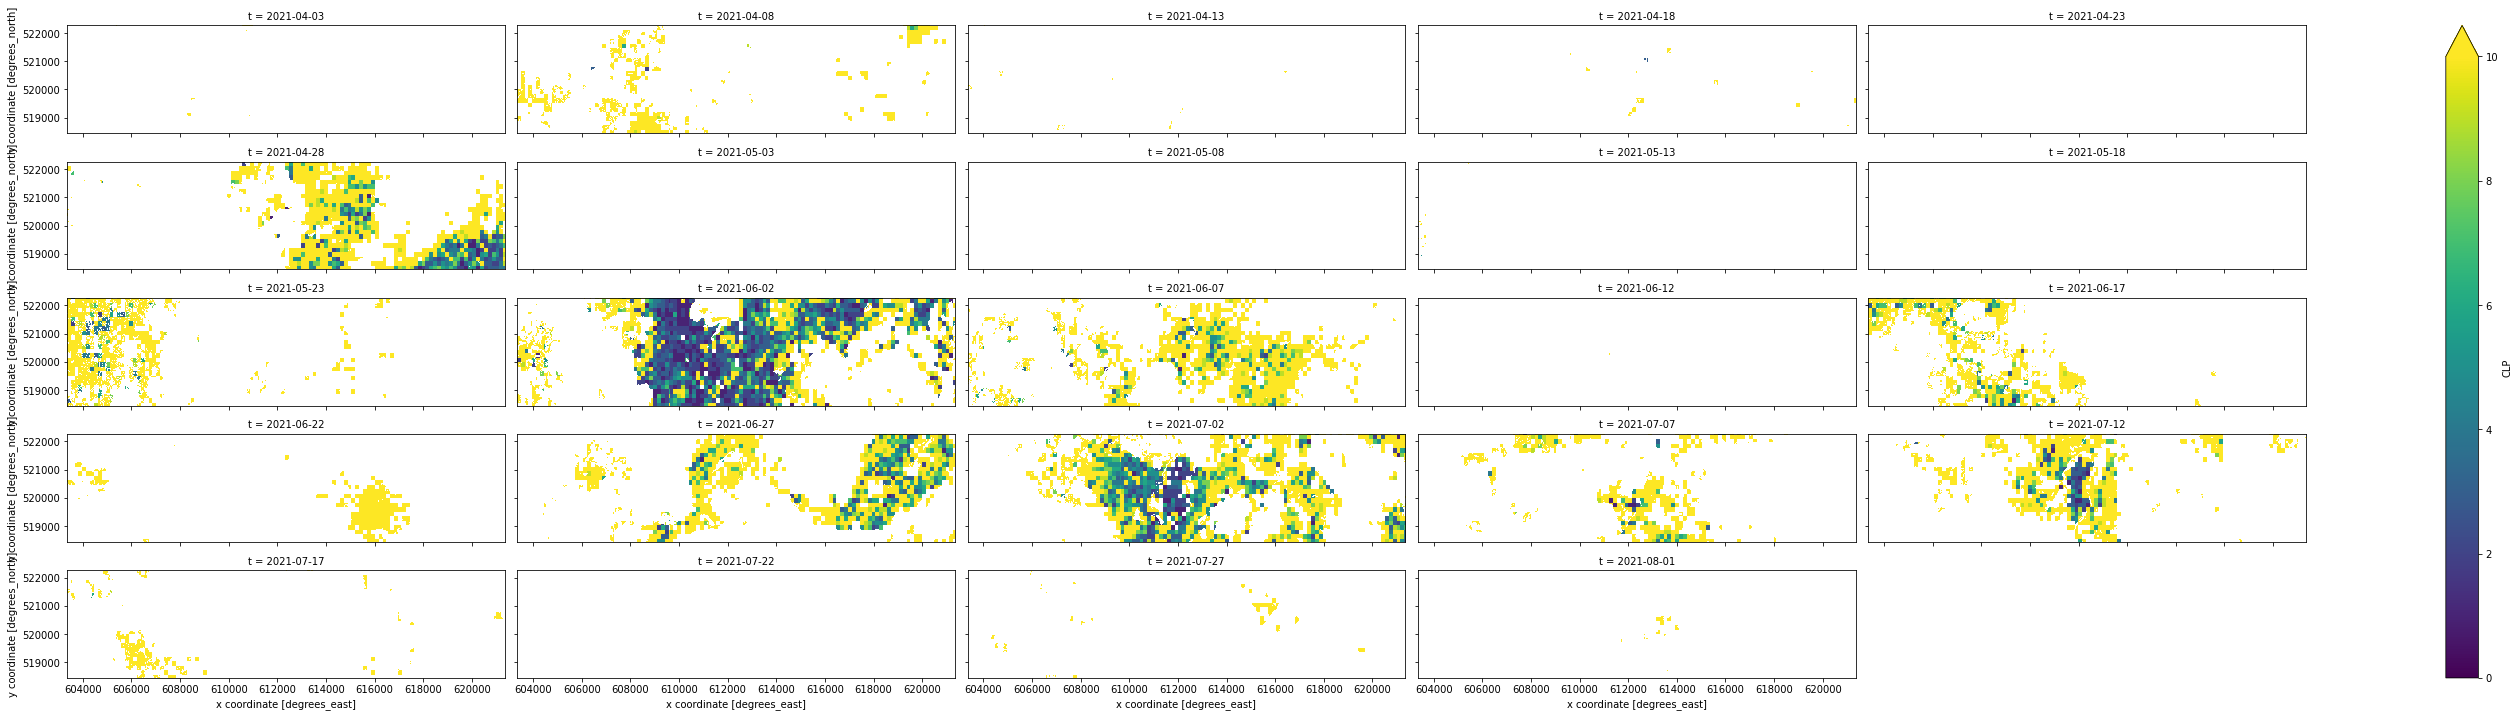

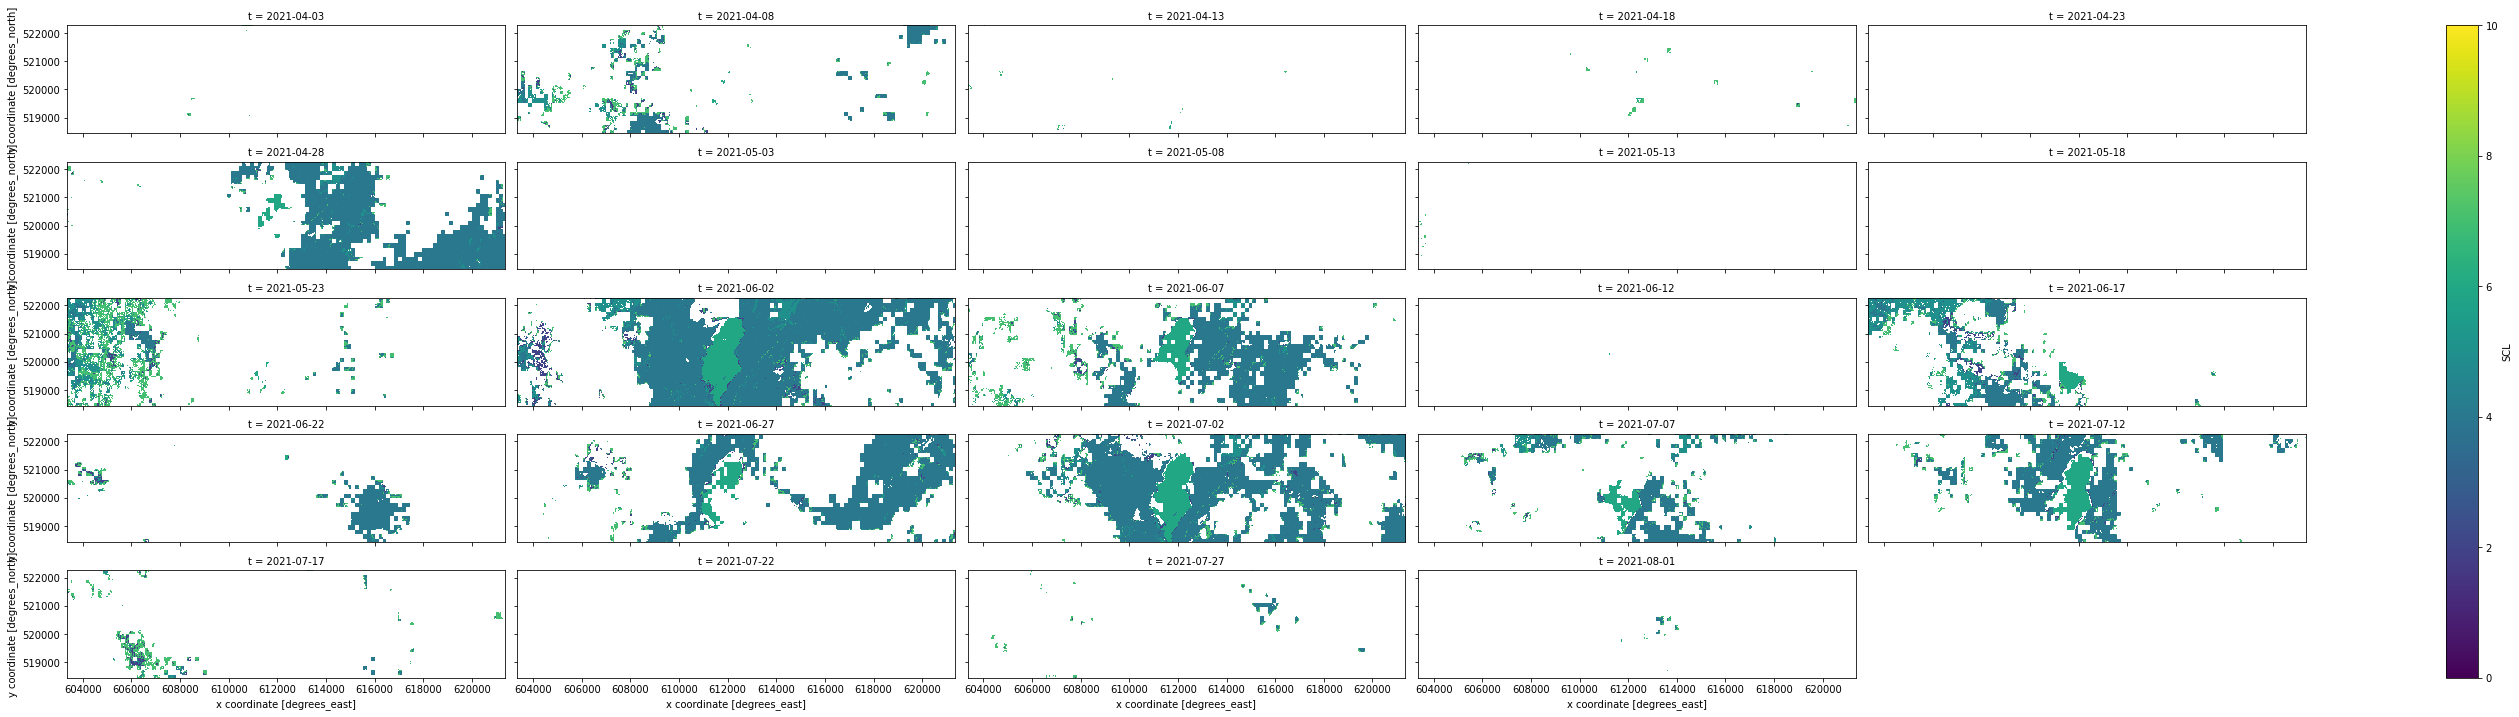

In [8]:
s2_cube_save = s2_cube.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_save.send_job(title="s2_cube_cloudfree")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_cloudfree") 

ds_s2_cube_masked = xr.open_dataset("s2_cube_cloudfree/openEO.nc")
ds_s2_cube_masked[['B02', 'B03', 'B04']].to_array().plot.imshow(x="x", robust=True, col ="t", col_wrap=5,vmin=0, vmax=3000, figsize=(40, 10)); 
ds_s2_cube_masked['CLP'].plot.imshow(x="x", robust=True, col ="t", col_wrap=5,vmin=0, vmax=10, figsize=(40, 10)); 
ds_s2_cube_masked['SCL'].plot.imshow(x="x", robust=True, col ="t", col_wrap=5,vmin=0, vmax=10, figsize=(40, 10)); 


*C) Mask Terrain Shadow*

In [10]:
dem_cube = connection.load_collection(
    "COPERNICUS_30",
    spatial_extent = spatial_extent,
    temporal_extent=["2010-01-01", "2030-12-31"])

dem_cube = dem_cube.max_time()


In [10]:
udf_code = """

from openeo.udf import XarrayDataCube
from hillshade.hillshade import hillshade

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    xarr = cube.get_array()
    if "t" in xarr.coords:
        xarr = xarr[{"t": 0}]
    if "bands" in xarr.coords:
        xarr = xarr[{"bands": 0}]
    
    elevation = xarr.values
    elevation = np.nan_to_num(elevation).clip(0, 8000)
    elevation = elevation.astype("float32")
    
    resolution = (30.0, 30.0)
    zenith = 15.0
    ray = (0.50, 1.0)
    ystart = 0
    yend = elevation.shape[1]
    
    shadow = hillshade(elevation, resolution, zenith, ray, ystart, yend)
    
    cube.get_array().values[0] = shadow
    return cube
"""
process = openeo.UDF(code=udf_code, runtime="Python", data={"from_parameter": "x"})
hillshaded = dem_cube.apply(process=process)
# s2_cube = s2_cube.mask(hillshaded)


- (Optional) Download and Visualize: 
1) S2 cube with masked terrain shadow
2) the DEM 
3) Terrain Shadow mask 

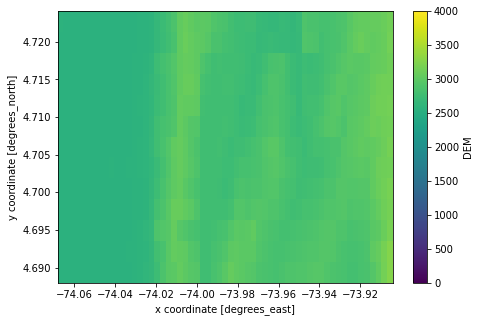

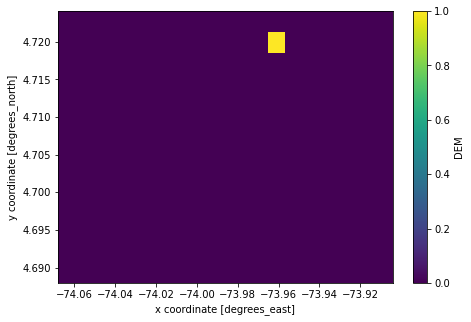

In [12]:
# s2_cube.download("s2_cube_hillshade.nc") 
#ds_s2_hillshaded = xr.load_dataset("s2_cube_hillshade.nc")
#ds_s2_hillshaded[['B02', 'B03', 'B04']].to_array().plot.imshow(x="x", robust=True, col ="t", col_wrap=5,vmin=0, vmax=3000, figsize=(40, 10)); 

dem_cube.download("dem.nc") 
ds_dem = xr.load_dataset("dem.nc")
ds_dem["DEM"].plot(vmin=0, vmax=4000, size = 5)


hillshaded.download("hillshaded.nc") 
ds_hillshaded = xr.load_dataset("hillshaded.nc")
ds_hillshaded["DEM"].plot(vmin=0, vmax=1, size = 5)

Get an image count (using B8) of all the non-masked areas

In [13]:

s2_count = s2_cube.filter_bands(bands = ["B08"])
s2_count = s2_count.reduce_dimension(reducer=lambda data: data.count(), dimension = "t")
s2_count = s2_count.add_dimension("bands", "count", type = "bands")


- (Optional) Download and Visualize

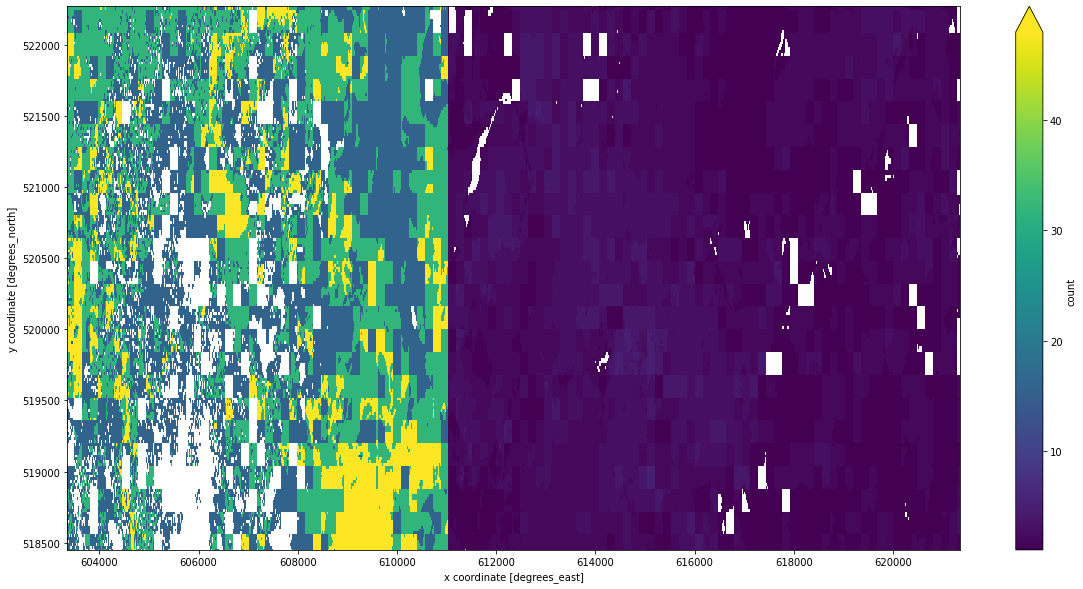

In [11]:

s2_count_save = s2_count.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_count_save.send_job(title="s2_count")
results = my_job.start_and_wait().get_results()
results.download_files("s2_count") 

ds_s2_count_cube = xr.open_dataset("s2_count/openEO.nc").load()
ds_s2_count_cube['count'].plot.imshow(x="x", robust=True, col_wrap=5, figsize=(20, 10)); #vmin=0, vmax=10,



D) NDVI and NDWI Calculation:
-   NDVI (Sentinel 2) = (B8 – B4) / (B8 + B4)
-   NDWI (Sentinel 2) = (B3 – B8) / (B3 + B8)

In [14]:
s2_cube = append_index(s2_cube,"NDWI") ## index 8
s2_cube = append_index(s2_cube,"NDVI") ## index 9

- (Optional) Download and Visualize

In [ ]:
# s2_cube.download("s2_cube_NDVI_NDWI.nc") 
s2_cube_save = s2_cube.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_save.send_job(title="s2_cube_NDVI_NDWI")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_NDVI_NDWI") 


ds_s2_cube_ndvi_ndwi = xr.open_dataset("s2_cube_NDVI_NDWI.nc").load()
ds_s2_cube_ndvi_ndwi
ds_s2_cube_ndvi_ndwi['NDVI'].plot.imshow(x="x", col = "t",  robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 
ds_s2_cube_ndvi_ndwi['NDWI'].plot.imshow(x="x", col = "t", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 


- E) *Calculate water probability for each image (Of the non-masked data)*

In [15]:
def water_function(data):
    NDWI = array_element(data, index = 8)
    NDVI = array_element(data, index = 9)
    water = eval(LOOKUPTABLE[zone]['S2'])
    return water

s2_cube_water = s2_cube.reduce_dimension(reducer = water_function, dimension = "bands")
s2_cube_water = s2_cube_water.add_dimension("bands", "water_prob", type = "bands") 


- (Optional) Download and Visualize

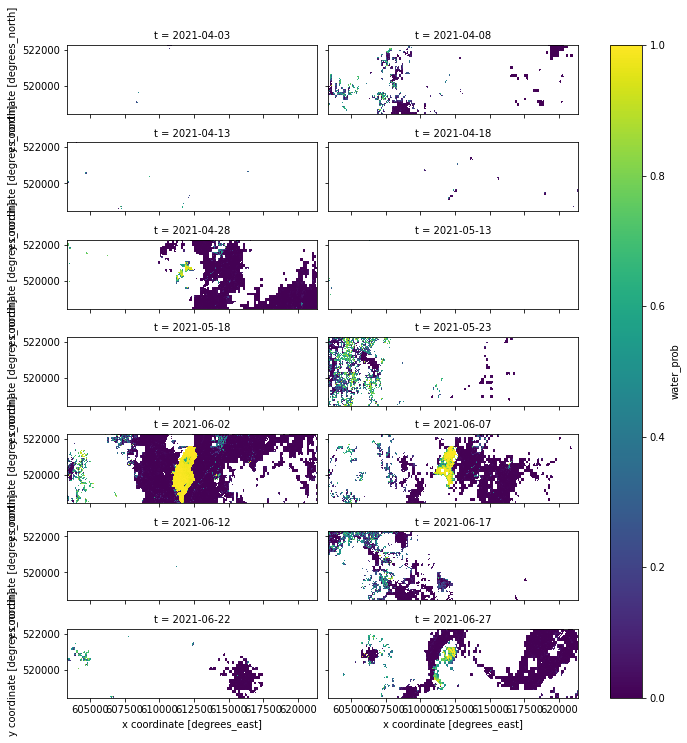

In [17]:

# s2_cube.download("s2_cube_NDVI_NDWI.nc") 
s2_cube_water_save = s2_cube_water.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_water_save.send_job(title="s2_cube_water")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_water") 


ds_s2_cube_water = xr.open_dataset("s2_cube_water/openEO.nc").load()
ds_s2_cube_water
ds_s2_cube_water['water_prob'].plot.imshow(x="x", col = "t",  robust=True, col_wrap=2, vmin=0, vmax=1, figsize=(10, 10)); 


- F) *Treshold of 75 on calculate water probability for each image*

In [16]:

s2_cube_water_threshold = s2_cube_water.apply_dimension(dimension="bands", process=lambda x: if_(x > 0.75, x))
s2_cube_water_threshold = s2_cube_water_threshold.add_dimension("bands", "w_T75", type = "bands")
 

- (Optional) Download and Visualize

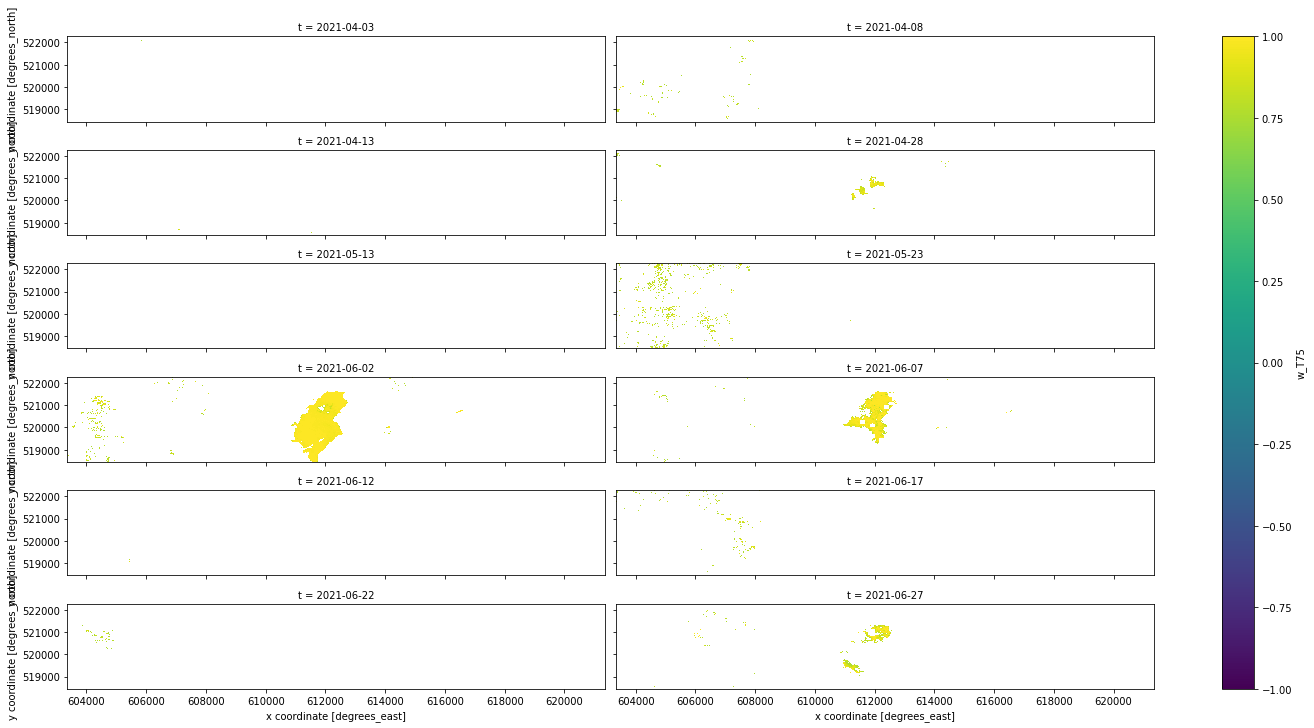

In [18]:
 
s2_cube_water_threshold_save = s2_cube_water_threshold.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_water_threshold_save.send_job(title="s2_cube_water_threshold")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_water_threshold")

ds_s2_cube_water_threshold = xr.open_dataset("s2_cube_water_threshold/openEO.nc").load()
ds_s2_cube_water_threshold
ds_s2_cube_water_threshold['w_T75'].plot.imshow(x="x", col = "t",  robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 



G) *Count the number of Sentinel-2 Water observations*

In [17]:

s2_cube_water_sum = s2_cube_water_threshold.reduce_dimension(reducer = "sum", dimension = "t")
s2_cube_water_sum = s2_cube_water_sum.add_dimension("bands", "sum", type = "bands") 


- (Optional) Download and Visualize

In [ ]:

s2_cube_water_sum_save = s2_cube_water_sum.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_water_sum_save.send_job(title="s2_cube_water_sum")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_water_sum") 

ds_s2_cube_water_sum = xr.open_dataset("s2_cube_water_sum/openEO.nc").load()
ds_s2_cube_water_sum
ds_s2_cube_water_sum['sum'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=0, vmax=8, figsize=(20, 10)); 



J) *Calculate the surface water frequency*

In [18]:
s2_merge_cubes =  

s2_cube_swf = s2_cube_water_sum / s2_count
s2_cube_swf = s2_cube_swf.add_dimension("bands", "swf", type = "bands") 


- (Optional) Download and Visualize

In [ ]:

s2_cube_swf_save = s2_cube_swf.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_swf_save.send_job(title="s2_cube_swf")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_swf") 

ds_s2_cube_swf = xr.open_dataset("s2_cube_swf/openEO.nc").load()
ds_s2_cube_swf['swf'].plot.imshow(x="x",robust=True, col_wrap=2, vmin=0, vmax=4, figsize=(20, 10)); 


C:\Users\ansu\AppData\Local\Temp\ipykernel_5172\533741983.py:2: DeprecationWarning: Call to deprecated method `send_job`, use `create_job` instead.
  my_job  = s2_cube_swf_save.send_job(title="s2_cube_swf")


0:00:00 Job 'j-738edda67fae482999c4f3a3b7c4cb12': send 'start'
0:00:31 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:00:36 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:00:43 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:00:51 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:01:02 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:01:14 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:01:30 Job 'j-738edda67fae482999c4f3a3b7c4cb12': queued (progress N/A)
0:01:50 Job 'j-738edda67fae482999c4f3a3b7c4cb12': running (progress N/A)
0:02:14 Job 'j-738edda67fae482999c4f3a3b7c4cb12': running (progress N/A)
0:02:44 Job 'j-738edda67fae482999c4f3a3b7c4cb12': running (progress N/A)
0:03:22 Job 'j-738edda67fae482999c4f3a3b7c4cb12': running (progress N/A)
0:04:09 Job 'j-738edda67fae482999c4f3a3b7c4cb12': running (progress N/A)
0:05:08 Job 'j-738edda67fae482999c4f3a3b7c4cb12': running (progress 

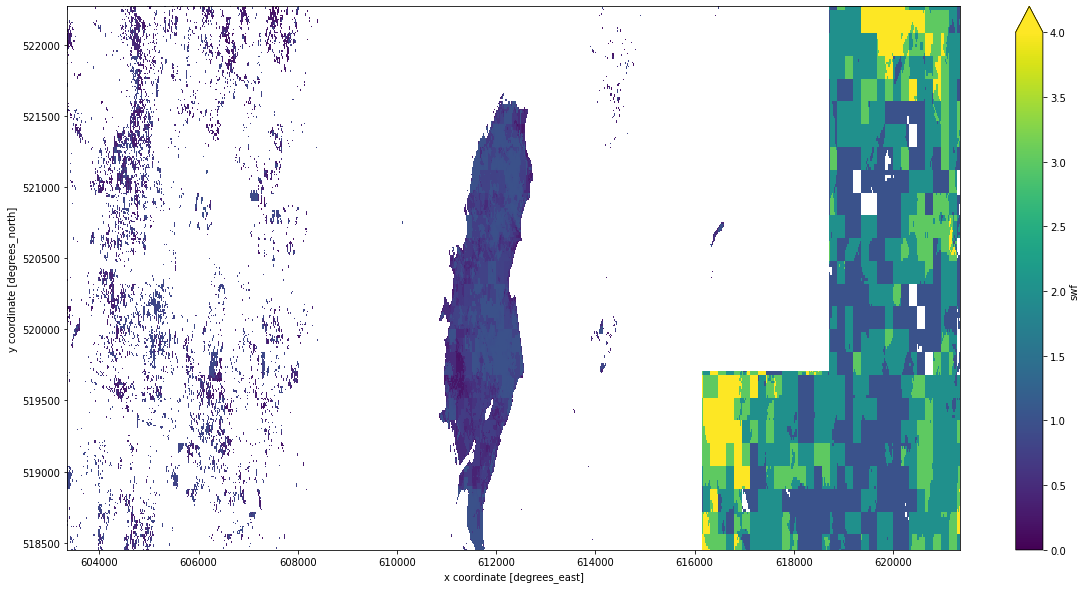

In [14]:

s2_cube_swf_save = s2_cube_swf.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_swf_save.send_job(title="s2_cube_swf")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_swf") 

ds_s2_cube_swf = xr.open_dataset("s2_cube_swf/openEO.nc").load()
ds_s2_cube_swf['swf'].plot.imshow(x="x",robust=True, col_wrap=2, vmin=0, vmax=4, figsize=(20, 10)); 


E) *Create Monthly Best-Pixel Mosaic*

In [19]:

## calculate the median s2 water probability for 1-month.
s2_median_water = s2_cube_water.filter_temporal([start_date, end_date]).median_time()
s2_median_water = s2_median_water.add_dimension("bands", "median", type = "bands")


- (Optional) Download and Visualize

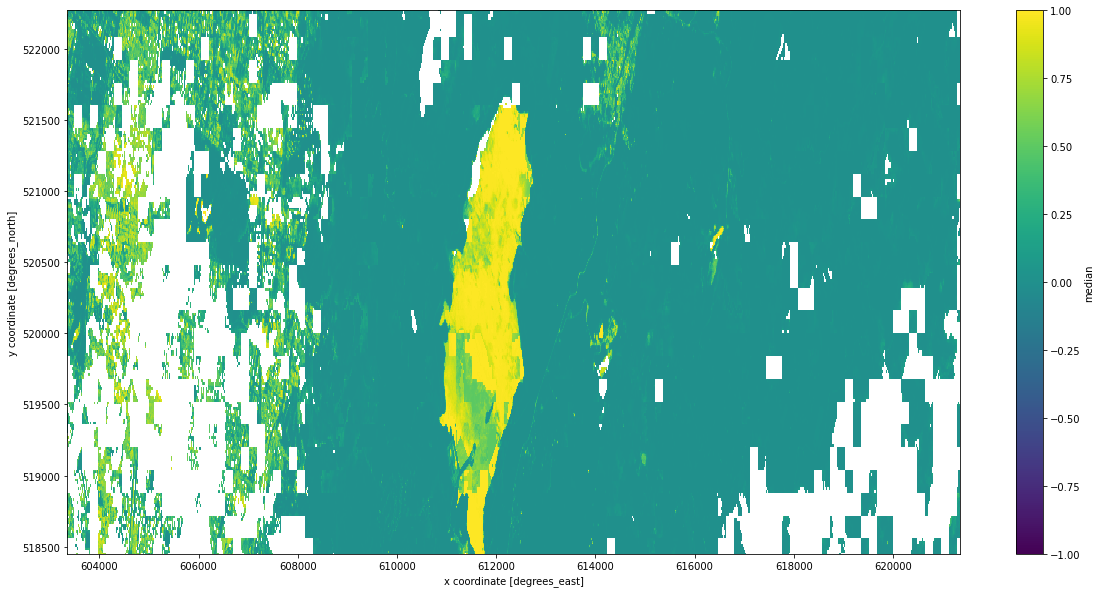

In [37]:

# Send cube to server
s2_median_water = s2_median_water.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_median_water.send_job(title="S2_L2A")
results = my_job.start_and_wait().get_results()
results.download_files("s2_median_water")

ds_s2_median_water = xr.open_dataset("s2_median_water/openEO.nc").load()
ds_s2_median_water
ds_s2_median_water['median'].plot.imshow(x="x",robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 


In [20]:
s2_cube_median = s2_cube.filter_temporal([start_date, end_date]).median_time()


- (Optional) check the S2 median composite

C:\Users\ansu\AppData\Local\Temp\ipykernel_26512\57131465.py:4: DeprecationWarning: Call to deprecated method `send_job`, use `create_job` instead.
  my_job  = s2_cube_median_save.send_job(title="s2_cube_median")


0:00:00 Job 'j-d6018803625a44cf86893478bfbe70a2': send 'start'
0:00:37 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:00:43 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:00:50 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:00:58 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:01:08 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:01:21 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:01:37 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:01:57 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:02:21 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:02:52 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:03:29 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:04:16 Job 'j-d6018803625a44cf86893478bfbe70a2': queued (progress N/A)
0:05:15 Job 'j-d6018803625a44cf86893478bfbe70a2': running (progress N/A)


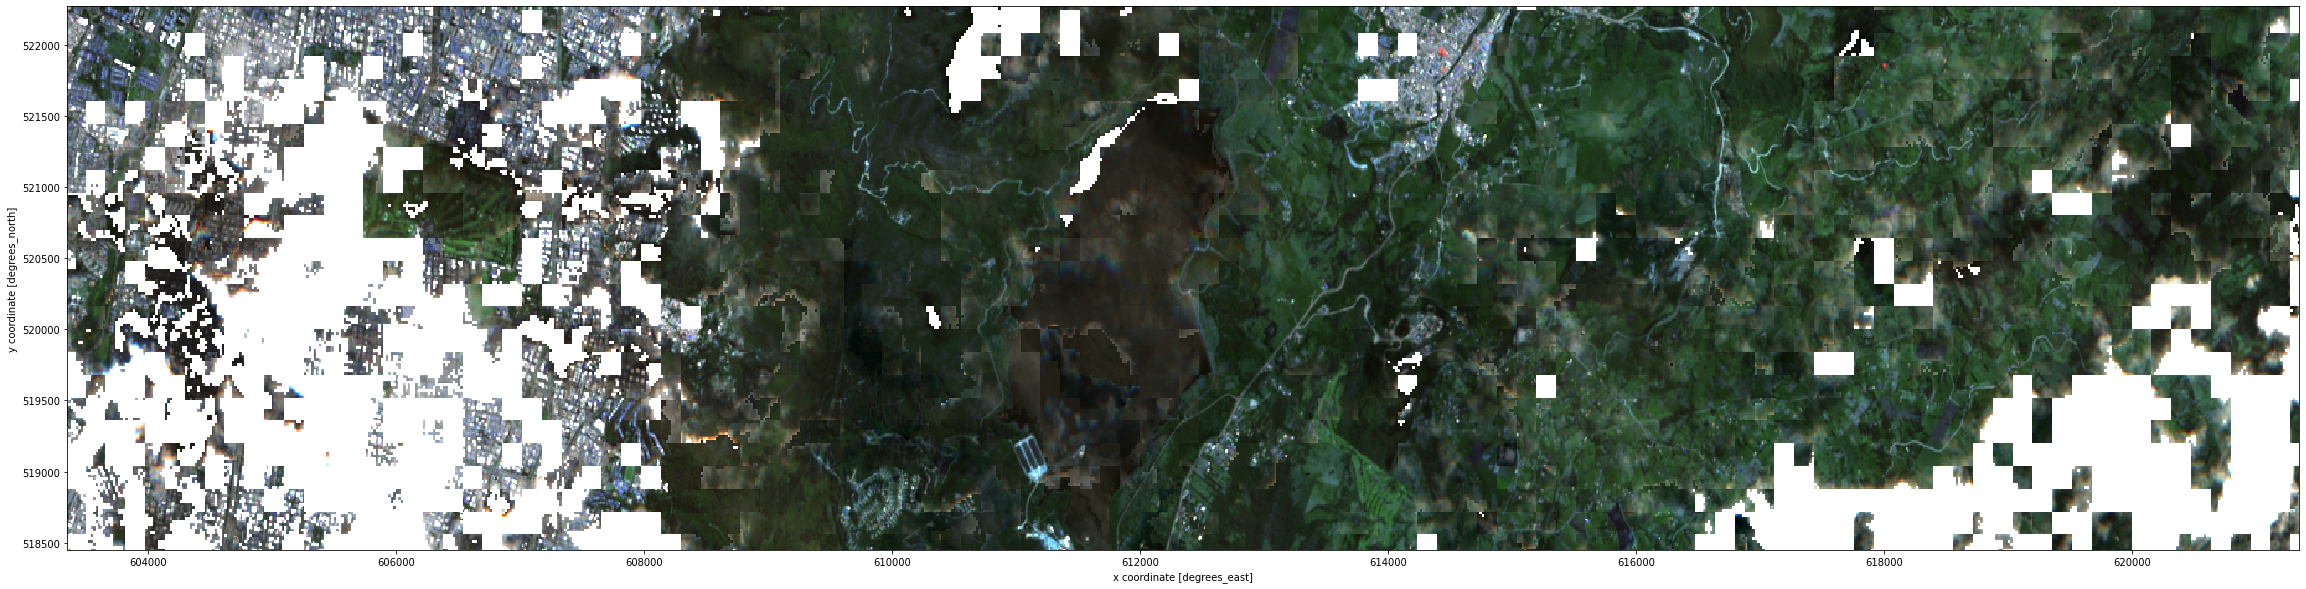

In [33]:


s2_cube_median_save = s2_cube_median.save_result(format='netCDF') #GTiff #netCDF
my_job  = s2_cube_median_save.send_job(title="s2_cube_median")
results = my_job.start_and_wait().get_results()
results.download_files("s2_cube_median")

ds_s2_median_water = xr.open_dataset("s2_cube_median/openEO.nc").load()
ds_s2_median_water[['B02', 'B03', 'B04']].to_array().plot.imshow(x="x", robust=True,  col_wrap=5,vmin=0, vmax=3000, figsize=(40, 10));
 

Check & download results: https://editor.openeo.org/

# 2) *Sentinel-1 ARD Pre-Processing*

Load Collection of Sentinel-1 

![Cat](images/S1_v2.png)

 Load Collection

In [21]:

## Get Sentinel-1 data for a 1 month window and convert to ARD data.
s1_cube = connection.load_collection(
    'SENTINEL1_GRD', 
     spatial_extent = spatial_extent, 
     temporal_extent = [start_date, end_date], 
     bands = ['VH','VV'],
     properties = {"polarization": lambda p: p == "DV"})


A) *Normalized Radar Backscatter*

*Terrain correction using COPERNICUS_30*

In [22]:

s1_cube = s1_cube.ard_normalized_radar_backscatter(elevation_model="COPERNICUS_30")


B) *Mask Radar Shadow*

In [23]:
s1_cube = s1_cube.rename_labels("bands",["VH","VV","mask", "incidence_angle"])
s1_cube_mask = s1_cube.band("mask")

# radar shadow mask has value 2
s1_mask_RS= (s1_cube_mask == 2)
s1_cube = s1_cube.mask(s1_mask_RS)


- (Optional) Download and Visualize of S1 images and mask

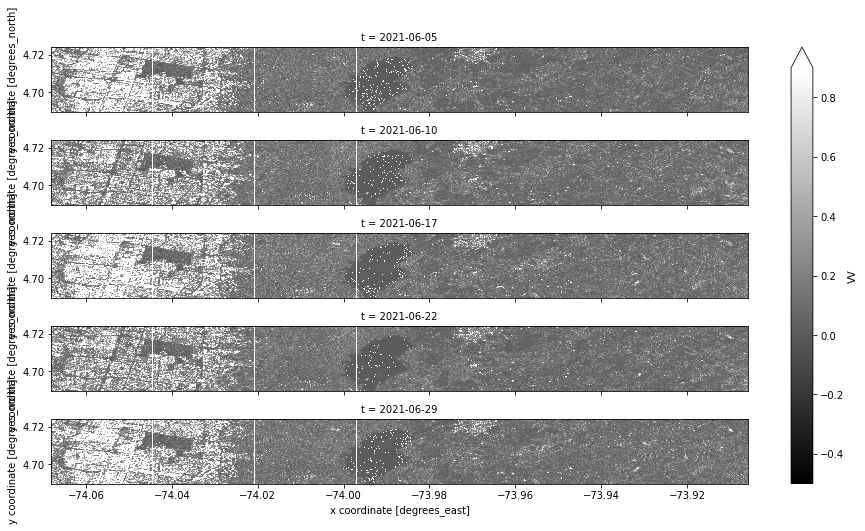

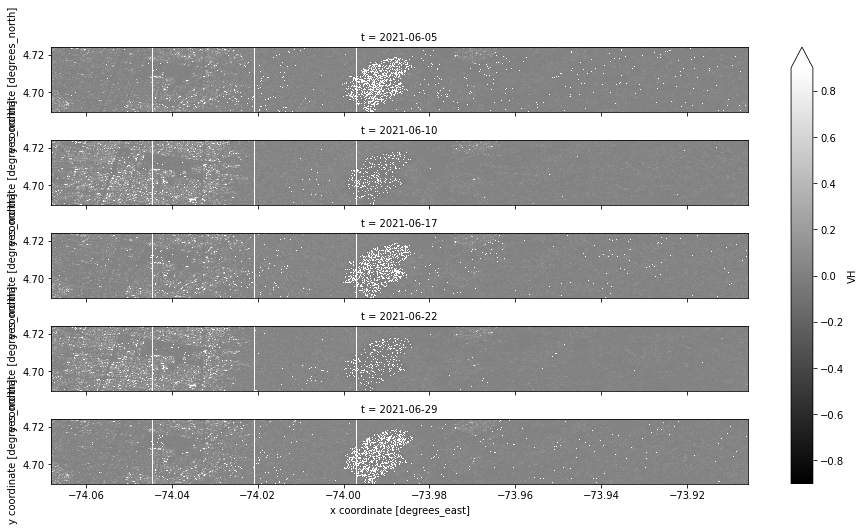

In [39]:
# s1_cube.download("s1_cube_mask_RS.nc")
ds_s1_cube_masked = xr.open_dataset("s1_cube_mask_RS.nc").load()
ds_s1_cube_masked['VV'].plot.imshow(col="t", col_wrap=1, cmap= 'gray', figsize=(13, 7), vmin= -0.5, vmax= 0.9) 
ds_s1_cube_masked['VH'].plot.imshow(col="t", col_wrap=1, cmap= 'gray', figsize=(13, 7), vmin= -0.9, vmax= 0.9)

- The final terrain-corrected values are converted to decibels via log scaling and calculation of median composite

In [24]:
def log_(x):
      return 10*log (x, 10)

s1_median = s1_cube.median_time().apply(log_) 


- (Optional) Download and Visualize of S1 median image

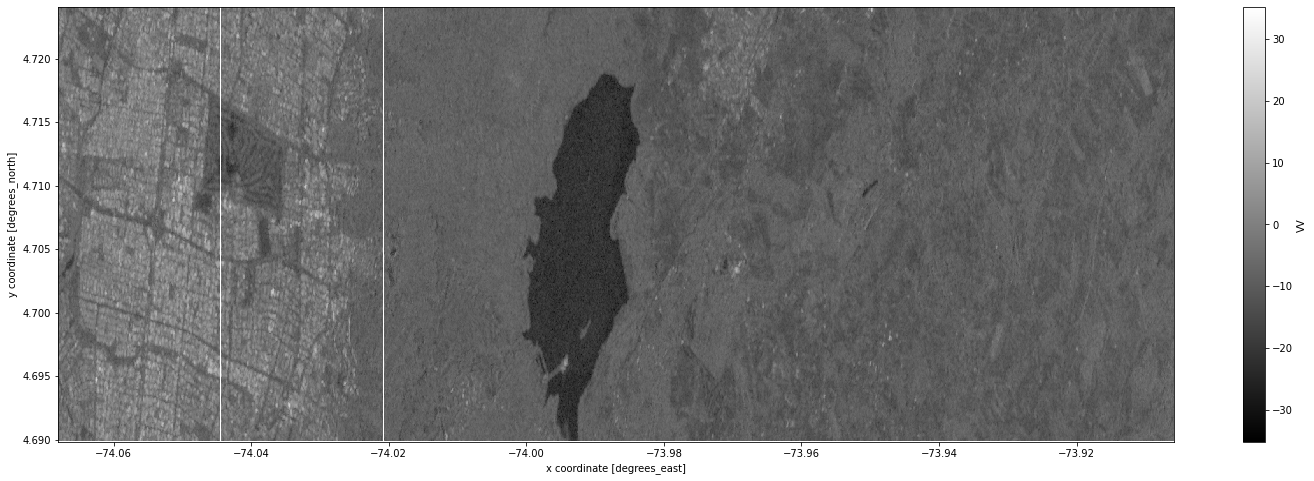

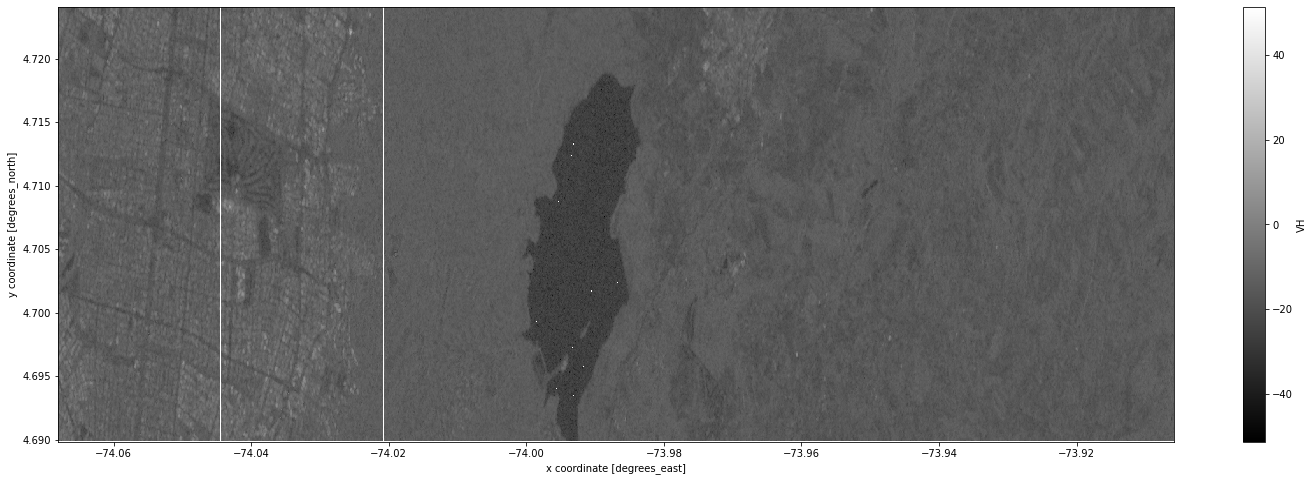

In [38]:
# s1_median.download("s1_median.nc")

ds_s1_cube_masked = xr.open_dataset("s1_median.nc").load()
ds_s1_cube_masked['VV'].plot.imshow(col_wrap=1, cmap= 'gray', figsize=(25, 8)) 
ds_s1_cube_masked['VH'].plot.imshow(col_wrap=1, cmap= 'gray', figsize=(25, 8)) 


C) *Calculate water probability for the S1 composite*

In [25]:
def s1_water_function(data):
    VV = array_element(data, index = 1)           
    water =  eval(LOOKUPTABLE[zone]['S1']) 
    return water

s1_median_water = s1_median.reduce_dimension(reducer = s1_water_function, dimension = "bands")
s1_median_water = s1_median_water.add_dimension("bands", "water_prob", type = "bands")


- (Optional) Download and Visualize 

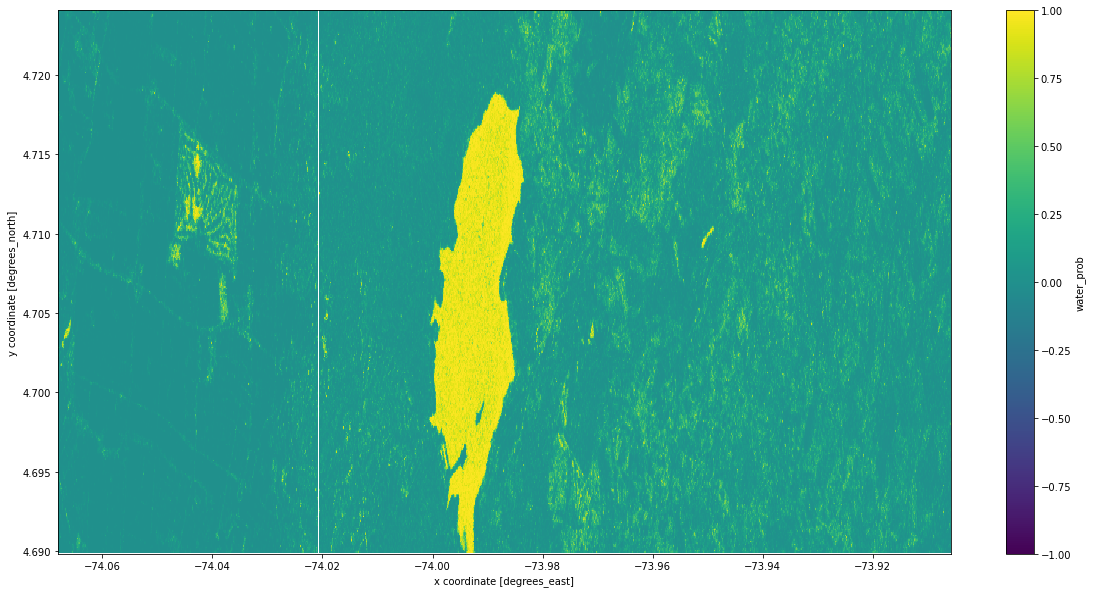

In [25]:
# s1_median_water.download("s1_median_water.nc")
ds_s1_median_water = xr.open_dataset("s1_median_water.nc").load()
ds_s1_median_water['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 


*D) Create an exclusion*

In [26]:
exclusion_mask = (s1_median_water.resample_cube_spatial(s2_cube_swf) > 0.5) & (s2_cube_swf < 0.33)
exclusion_mask = exclusion_mask * 1.0

- (Optional) Download and Visualize 

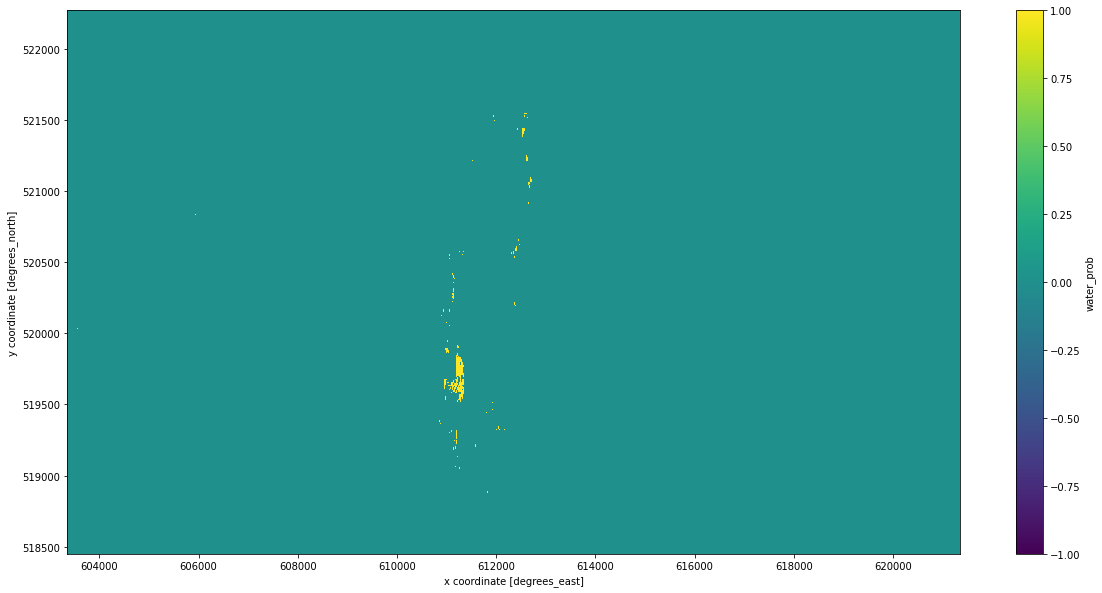

In [34]:
exclusion_mask_save = exclusion_mask.save_result(format='netCDF') #GTiff #netCDF
my_job  = exclusion_mask_save.create_job(title="exclusion_mask")
results = my_job.start_and_wait().get_results()

results.download_files('exclusion_mask')
ds_exclusion_mask = xr.open_dataset("exclusion_mask/openEO.nc").load()
ds_exclusion_mask
ds_exclusion_mask['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 


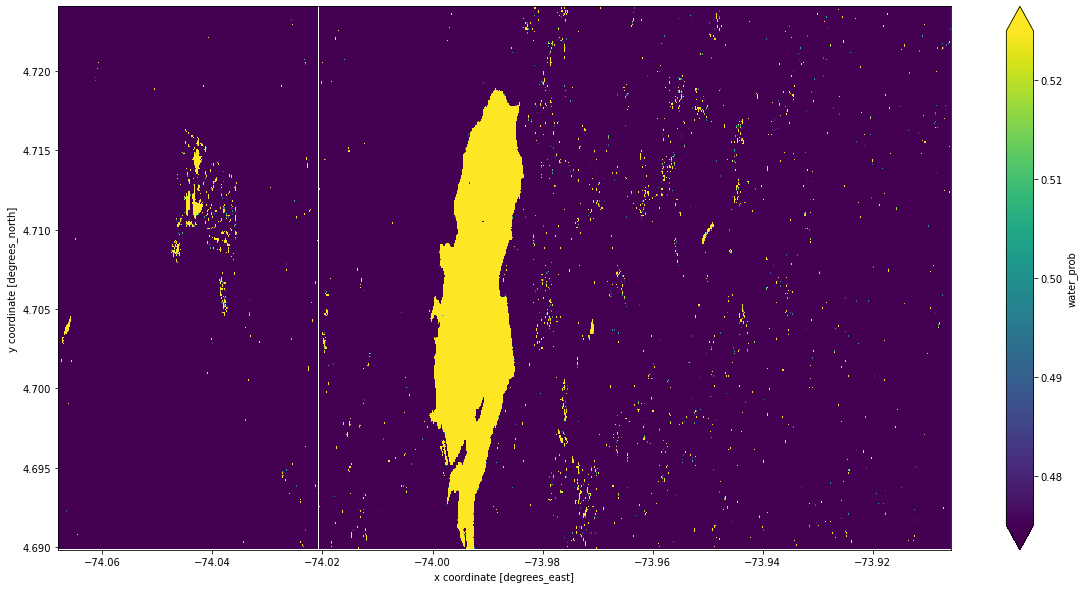

In [41]:
ds_s1_median_water = xr.open_dataset("s1_median_water.nc").load()
ds_s1_median_water['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=0.5, vmax=0.5, figsize=(20, 10)); 

*E) Mask Sentinel-1 by the exlusion mask*

In [28]:
s1_median_water_mask = s1_median_water.resample_cube_spatial(exclusion_mask).mask(exclusion_mask)
s1_median_water_mask = s1_median_water_mask * 1.0

- (Optional) Download and Visualize 

In [29]:
# s1_median_water.download("s1_median_water_mask.nc")
s1_median_water_mask_save = s1_median_water_mask.save_result(format='netCDF') #GTiff #netCDF
my_job  = s1_median_water_mask_save.send_job(title="s1_median_water_mask")
results = my_job.start_and_wait().get_results()

results.download_files('s1_median_water_mask')
ds_s1_median_water = xr.open_dataset("s1_median_water_mask/openEO.nc").load()
ds_s1_median_water['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 


C:\Users\ansu\AppData\Local\Temp\ipykernel_12520\351529652.py:3: DeprecationWarning: Call to deprecated method `send_job`, use `create_job` instead.
  my_job  = s1_median_water_mask_save.send_job(title="s1_median_water_mask")


0:00:00 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': send 'start'
0:00:20 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:00:26 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:00:32 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:00:40 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:00:51 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:01:03 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:01:19 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:01:38 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:02:03 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:02:33 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:03:11 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:03:58 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0:04:56 Job 'j-50f22a80d68544fc8d9b7ff9c69f51df': queued (progress N/A)
0

KeyboardInterrupt: 

Check & download results: https://editor.openeo.org/

# 3) Water Masking

![Cat](images/WM_v1.png)

- A) Load LUT and run logistic expressions


In [27]:
def s1_s2_water_function (dc):
    VV = array_element(dc, index = 0)       
    NDWI = array_element(dc, index = 1)  
    water = eval(LOOKUPTABLE[zone]['S1_S2'])  
    return water


## Get S1 VV, and S2 NDWI, and apply s1_s2_water function
s1_s2_cube = s1_median.filter_bands(['VV']).merge_cubes(s2_cube_median.filter_bands(['NDWI']))
s1_s2_water = s1_s2_cube.reduce_dimension(reducer = s1_s2_water_function, dimension = "bands").mask(exclusion_mask)


- (Optional) Download and Visualize 

In [ ]:

s1_s2_water_save = s1_s2_water.save_result(format='netCDF') #GTiff #netCDF
my_job  = s1_s2_water_save.send_job(title="s1_s2_water")
results = my_job.start_and_wait().get_results()
results.download_files('s1_s2_water')

In [ ]:
## create the masks so that the data is independent of each other.
s1_s2_mask = s1_s2_water >= 0
s2_mask = s2_median_water.mask(s1_s2_mask) >= 0
s1_mask = s1_median_water.mask(s1_s2_mask).mask(s2_mask) >= 0
# nodata_mask

## download and check the masks
s1_s2_mask.download('s1_s2_mask.tif')
s2_mask.download('s2_mask.tif')
s1_mask.download('s1_mask.tif')

In [ ]:

## masks need to be inverted.
s1_s2_masked = s1_s2_water.mask(s1_s2_mask.apply(lambda x: x.eq(0)), replacement = 0)
s2_masked = s2_median_water.mask(s2_mask.apply(lambda x: x.eq(0)), replacement = 0)
s1_masked = s1_median_water.mask(s1_mask.apply(lambda x: x.eq(0)), replacement = 0)


## download and check probabilities are correct after masking.
s1_s2_masked.download('s1_s2_masked-v2.tif')
s2_masked.download('s2_masked-v2.tif')
s1_masked.download('s1_masked-v2.tif')


merge1 = s1_s2_masked.merge_cubes(s2_masked, overlap_resolver='sum')
merge2 = merge1.merge_cubes(s1_masked, overlap_resolver='sum')
merge2.download('composite-probability.tif')


*D) Mask Urban Areas*

In [ ]:
worldcover_cube = connection.load_collection("ESA_WORLDCOVER_10M_2020_V1", 
                                            temporal_extent = [start_date, end_date], 
                                            spatial_extent = spatial_extent, 
                                            bands = ["MAP"])
                                            #.filter_bbox({'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]})

builtup_mask = worldcover_cube.band("MAP") != 50

water_probability = merge2.mask(builtup_mask)

- (Optional) Download and Visualize 

In [ ]:
water_probability_save = water_probability.save_result(format='netCDF') #GTiff #netCDF
my_job  = water_probability_save.send_job(title="water_probability_save")
results = my_job.start_and_wait().get_results()
results.download_files('water_probability_save')

ds_water_probability = xr.open_dataset("water_probability_save/openEO.nc").load()
# ds_water_probability['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 
ds_water_probability

*E) Threshold water and create a bitmask*

In [ ]:
water_T75 = water_probability > 0.75


In [ ]:
water_T75_save = water_T75.save_result(format='netCDF') #GTiff #netCDF
my_job  = water_T75_save.send_job(title="water_T75")
results = my_job.start_and_wait().get_results()
results.download_files('water_T75')

ds_water_T75 = xr.open_dataset("water_T75/openEO.nc").load()
# ds_water_probability['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 
ds_water_T75

In [ ]:
bitmask = water_T75.mask(water_T75.apply(lambda x: x.eq(0)), replacement = 0)

- (Optional) Download and Visualize 

In [ ]:
bitmask_save = water_T75.save_result(format='netCDF') #GTiff #netCDF
my_job  = bitmask_save.send_job(title="bitmask")
results = my_job.start_and_wait().get_results()
results.download_files('bitmask')

ds_bitmask = xr.open_dataset("bitmask/openEO.nc").load()
# ds_water_probability['water_prob'].plot.imshow(x="x", robust=True, col_wrap=2, vmin=-1, vmax=1, figsize=(20, 10)); 
ds_bitmask